In [153]:
!pip3 install -U openai

In [154]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import json
from openai import OpenAI
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
import re
import warnings

In [155]:
API_KEY = "sk-f86318f6dea54fd6a11b19fcc3a7b81f"

In [156]:
input_type_csv = True

In [157]:
if input_type_csv: 
    deepseek_v3_output_df = pd.read_csv('/Users/faresg/Desktop/MSc AI A&I/ML for Actionable Decison Making/Project/output_df.csv', delimiter=',')

deepseek_v3_output_df.head()
print(deepseek_v3_output_df.isna().sum())
deepseek_v3_output_df.dropna(inplace=True)

clinical_note                    0
true_triage                      0
predicted_triage                 0
triage_severity_index            0
reasoning                        0
verification_and_reassessment    0
probability                      0
dtype: int64


In [158]:
system_prompt_1 = """
You are an expert ER Doctor who is asked to validate a medical triage classification assignment based on the Emergency Severity Index (ESI) classification. You will carefully evaluate the given patient summary, the triage reasoning and the triage classfication using the below framework. 
Patient Summary: 
"""
system_prompt_2 = """

Triage Classification: 
"""

system_prompt_3 = """

Reasoning for the Triage Classification:
"""

system_prompt_4 = """

Use ESI classification for triaging, which follows the following framework:
The ESI assigns patients to one of five levels based on the severity of their condition and the medical resources they are likely to require:
Level 1 (Immediate): Immediate, life-saving intervention required without delay. Examples - Cardiac arrest; Pulseless/Unresponsive; Profound hypotension or hypoglycemia; Major trauma with hemodynamic instability
Level 2 (Emergent): High risk of deterioration, or signs of a time-critical problem. Examples - Cardiac-related chest pain; Severe Asthma exacerbation (stable vitals but in significant distress); Altered mental status; Potential stroke (Alert but high risk)
Level 3 (Urgent): Stable, with multiple types of resources needed to investigate or treat (such as lab tests plus diagnostic imaging). Examples - Non-critical Abdominal pain needing labs + CT ; High fever with cough; Persistent headache; Stable orthopedic injury needing imaging + Possible reduction; Moderate respiratory complaint needing labs, nebulizer, and possible imaging
Level 4 (Semi-Urgent): Stable, with only one type of resource anticipated (such as only an x-ray, or only sutures). Examples - Simple extermity injury needing a single x-ray; Sore throat needing one swab; UTI needing only a urine test; Rabies vaccination
Level 5 (Non-Urgent): Stable, with no resources anticipated except oral or topical medications, or prescriptions. Examples - Medication refill; Minor rash needing visual exam only; Suture removal; Foreign body in eye; Stable earache with exam and antibiotic prescription
 
ESI Decision Framework: Goal - Indentify who needs to be seen immediately and anticipate the resources needed for each patient.
STEP 1: Check for Immediate Life-Threatening Conditions (ESI Level 1)
Assess Airway/Breathing/Circulation (ABCs) - Apneic or pulseless? Severe respiratory distress? Profound hypotension? Requires immediate lifesaving intervention (e.g., intubation, emergent fluid resuscitation)? Assign ESI Level 1.
Unresponsive Patients - No verbal response or follows no commands (acutely)? Requires painful stimulus to respond? Assign ESI Level 1.

STEP 2: Determine if High-Risk (ESI Level 2)
If not ESI 1, check:
High-Risk Symptoms - Possible stroke, chest pain suspicious for ACS, ectopic pregnancy, suicidal/homicidal ideation, immunocompromised with fever? Assign ESI Level 2.
Acute Change in Mental Status - New confusion, lethargy, agitation, or disorientation? Assign ESI Level 2.
Severe Pain or Distress - Pain severity ≥7/10 with signs of systemic distress (e.g., sickle cell crisis)? Assign ESI Level 2.

STEP 3: Estimate Number of Resources (ESI Levels 3, 4, 5)
If not ESI Level 1 or Level 2, predict how many different resources will be needed for diagnosis/treatment:
ESI Level 3: Likely needs 2 or more resources - e.g., labs + imaging, IV meds + ultrasound, consults 
ESI Level 4: Likely needs 1 resource - e.g., single X-ray or strep test only
ESI Level 5: Likely needs 0 resources - e.g., minor complaint needing exam & simple prescription
What counts as a 'resource'? Labs (all labs = 1), any imaging (X-ray, CT, ultrasound), IV fluids/meds, consults, procedures
What does not count as a resource?: Physical exam alone, PO meds at triage, simple wound care, phone call to PCP, tetanus shot

STEP 4: Evaluate Vital Signs
For ESI Level 3 patients, check full vitals (HR, RR, BP, SpO₂).
Reassess if vitals are abnormal for age/condition. Abnormal values include heart rate > 100 bpm, respiratory rate > 20 breaths/min, oxygen saturation ≤ 92%, systolic blood pressure < 90 mmHg (hypotension), and temperature ≥ 38.0°C (100.4°F) or ≤ 36.0°C (96.8°F). If vitals suggest instability, up-triage to ESI Level 2.

Evaluation Instructions:
After reviewing the patient summary, triage classification and the reasoning for the Triage Classification, follow these steps:
1. Verify if the reasoning is medically accurate and consistent with the patient summary.
2. If it is not then identify any assumptions made and clarify areas where certainty is lower.
3. If there are any discrepancies in assumptions or inference, then correct them.
4. If any discrepancies are identified, reassign a triage classification based on the verification process. 
5. Enclose your triage classifcation between Level 1 to 5 in a <triage_classification> tag.
6. If there is a discrepancy, provide a keyword for the discrepancy and enclose it in a <discrepancy> tag. e.g., Medical inaccuracy, Incorrect reasoning, Missing information, etc.
 
Important Notes:
Always ensure medical accuarcy. Use clear, professional language.
"""

In [159]:
triage_mapping = {"Level 1" : "Immediate",
                  "Level 2" : "Emergent",
                  "Level 3" : "Urgent",
                  "Level 4" : "Semi-urgent",
                  "Level 5" : "Nonurgent"
}

In [160]:
client = OpenAI(
    api_key=API_KEY,
    base_url="https://api.deepseek.com",
)

In [161]:
def call_deepseek_r1(clinical_note, predicted_triage, reasoning):
    # Compose your complete input prompt (you can modify system_prompt_1 and system_prompt_2 as needed)
    input_prompt = system_prompt_1 + clinical_note + system_prompt_2 + predicted_triage + system_prompt_3 + reasoning + system_prompt_4
    messages = [{"role": "user", "content": input_prompt}]
    
    # Call the OpenAI API
    response = client.chat.completions.create(
        model="deepseek-reasoner",         # DeepSeek R1
        messages=messages,                  
        temperature=0.14                  
    )

    return response.choices[0].message.content

In [167]:
# Initialize a list to store true labels and predictions
true_labels = []
predictions = []
discrepancies = []

# Iterate over the test dataset
for index, case in deepseek_v3_output_df.iterrows():
    print(index)
    # Extract the clinical note and true triage level
    clinical_note = case["clinical_note"]
    predicted_triage = case["predicted_triage"]
    true_label = case["true_triage"][:-1]
    reasoning = case["reasoning"]

    full_output = call_deepseek_r1(clinical_note, predicted_triage, reasoning)
    #print(full_output)
    
    # Extract the predicted triage level from the response
    match_pred = re.search(r'<triage_classification>(.*?)</triage_classification>', full_output)
    predicted_label = match_pred.group(1).strip() if match_pred else None

    match_discrepancy = re.search(r'<discrepancy>(.*?)</discrepancy>', full_output)
    discrepancy = match_discrepancy.group(1).strip() if match_discrepancy else None
    
    # Append the true label and prediction to the lists
    true_labels.append(true_label)
    predictions.append(predicted_label if predicted_label else "NA")
    discrepancies.append(discrepancy if discrepancy else "None")
    #print(f'True: {true_label}, Predicted V3: {predicted_triage}, Predicted R1: {triage_mapping.get(predicted_label)}, Discrepancy: {discrepancy}\n')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [168]:
v3_results = []
for index, case in deepseek_v3_output_df.iterrows():
    if index > 99:
        accuracy = accuracy_score(true_labels[:99], [triage_mapping.get(pred) for pred in predictions[:99]])
        print(f"Accuracy: {accuracy:.2f}")
        break
    else:
        predicted_triage = case["predicted_triage"]
        print(f"True: {true_labels[index]}, Predicted V3: {predicted_triage}, Predicted R1: {triage_mapping.get(predictions[index])}")
        v3_results.append(predicted_triage)

True: Urgent, Predicted V3: Urgent, Predicted R1: Emergent
True: Urgent, Predicted V3: Emergent, Predicted R1: Emergent
True: Urgent, Predicted V3: Urgent, Predicted R1: Urgent
True: Semi-urgent, Predicted V3: Nonurgent, Predicted R1: Semi-urgent
True: Semi-urgent, Predicted V3: Semi-urgent, Predicted R1: Semi-urgent
True: Emergent, Predicted V3: Semi-urgent, Predicted R1: Urgent
True: Urgent, Predicted V3: Urgent, Predicted R1: Urgent
True: Semi-urgent, Predicted V3: Semi-urgent, Predicted R1: Semi-urgent
True: Emergent, Predicted V3: Urgent, Predicted R1: Urgent
True: Semi-urgent, Predicted V3: Semi-urgent, Predicted R1: Semi-urgent
True: Semi-urgent, Predicted V3: Urgent, Predicted R1: Emergent
True: Urgent, Predicted V3: Urgent, Predicted R1: Emergent
True: Urgent, Predicted V3: Urgent, Predicted R1: Urgent
True: Urgent, Predicted V3: Semi-urgent, Predicted R1: Emergent
True: Emergent, Predicted V3: Urgent, Predicted R1: Urgent
True: Semi-urgent, Predicted V3: Urgent, Predicted R1:

In [169]:
accuracy = accuracy_score(true_labels, [triage_mapping.get(pred) for pred in predictions])
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.48


In [170]:
triage_value = {"Immediate": 5,
                "Emergent": 4,
                "Urgent": 3,
                "Semi-urgent": 2,
                "Nonurgent": 1,
                "NA": 0
}

In [171]:
def plot_conf_matrix(cm, flag, text_labels=None):
    plt.figure(figsize=(6, 5))
    if flag == "multi":
        text_labels = ["NA", "Nonurgent", "Semi-urgent", "Urgent", "Emergent", "Immediate"] 
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=text_labels, yticklabels=text_labels)
    elif flag == "binary":
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=text_labels, yticklabels=text_labels)
    else:
        print("Invalid flag. Please use 'multi' for multi-class classification and 'binary' for binary classification.")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [172]:
def global_metrics(true_labels, predictions, levels):
    # --- Global Metrics ---
    predictions_mapped = [triage_mapping.get(pred) for pred in predictions]
    global_accuracy = accuracy_score(true_labels, predictions_mapped)
    global_conf_matrix = confusion_matrix([triage_value.get(label) for label in true_labels], [triage_value.get(pred) for pred in predictions_mapped], labels=range(len(levels)))

    underreport = 0
    overreport = 0
    total_wrong = 0

    for i in range(len(true_labels)):
        pred_label_value = triage_value.get(predictions_mapped[i])
        true_label_value = triage_value.get(true_labels[i])
        # Compare predicted and true level (both assumed numeric or ordered)
        if pred_label_value < true_label_value:
            underreport += 1
            total_wrong += 1
        elif pred_label_value > true_label_value:
            overreport += 1
            total_wrong += 1
        else:
            continue
        
    underreport_pct = (underreport / total_wrong) * 100 if total_wrong > 0 else 0
    overreport_pct = (overreport / total_wrong) * 100 if total_wrong > 0 else 0
    
    print("Global Metrics:")
    print(f"Accuracy: {global_accuracy:.3f}")
    print("Confusion Matrix:")
    print(global_conf_matrix)

    plot_conf_matrix(global_conf_matrix, flag="multi")

    print(f"Undereporting % (predicted < true) of wrong predictions: {underreport_pct:.2f}%")
    print(f"Overreporting % (predicted > true) of wrong predictions: {overreport_pct:.2f}%")

In [173]:
def per_triage_level_metrics(true_labels, predictions, levels):
    print("\nPer Triage Level Metrics:")
    predictions_mapped = [triage_mapping.get(pred) for pred in predictions]
    for level in levels:
        # Filter indices where the true label is equal to the current level.
        indices = [i for i, lab in enumerate(true_labels) if lab == level]
        if len(indices) == 0:
            print(f"\nNo cases of Triage Level: {level}\n")
            continue
        
        # Get true and predicted for this subset.
        true_subset = [true_labels[i] for i in indices]
        pred_subset = [predictions_mapped[i] for i in indices]
        
        # Accuracy for current triage level: proportion of cases correctly predicted within the subset.
        level_accuracy = accuracy_score(true_subset, pred_subset)
        
        # For binary AUC (current level vs all others), create binary labels and probability list.

        binary_true = [1 if lab == level else 0 for lab in true_labels]

        # Build a binary confusion matrix:
        # Predicted positive if predicted label equals current level, negative otherwise.
        binary_pred = [1 if pred == level else 0 for pred in predictions_mapped]
        level_conf_matrix = confusion_matrix(binary_pred, binary_true)
        
        # Compute underreporting and overreporting rates for cases where the true level is 'level'.
        # Here we assume the triage levels are ordinal so that a lower number means lower severity.
        underreport = 0
        overreport = 0
        total_wrong = 0

        for i in range(len(true_subset)):
            pred_label_value = triage_value.get(pred_subset[i])
            true_label_value = triage_value.get(true_subset[i])
            # Compare predicted and true level (both assumed numeric or ordered)
            if pred_label_value < true_label_value:
                underreport += 1
                total_wrong += 1
            elif pred_label_value > true_label_value:
                overreport += 1
                total_wrong += 1
            else:
                continue
        
        underreport_pct = (underreport / total_wrong) * 100 if total_wrong > 0 else 0
        overreport_pct = (overreport / total_wrong) * 100 if total_wrong > 0 else 0
   
        print(f"\nTriage Level: {level}")
        print(f"Accuracy: {level_accuracy:.3f}")
        
        print("Confusion Matrix:")
        print(level_conf_matrix)

        plot_conf_matrix(level_conf_matrix, flag="binary", text_labels=["Not " + level, level])
        
        print(f"Undereporting % (predicted < true) of wrong predictions: {underreport_pct:.2f}%")
        print(f"Overreporting % (predicted > true) of wrong predictions: {overreport_pct:.2f}%")

Global Metrics:
Accuracy: 0.480
Confusion Matrix:
[[ 0  0  0  0  0  0]
 [ 0  1  1  1  0  0]
 [ 0  0 12 10  7  0]
 [ 0  0  4 23 19  0]
 [ 0  1  0  6 11  0]
 [ 0  0  1  0  2  1]]


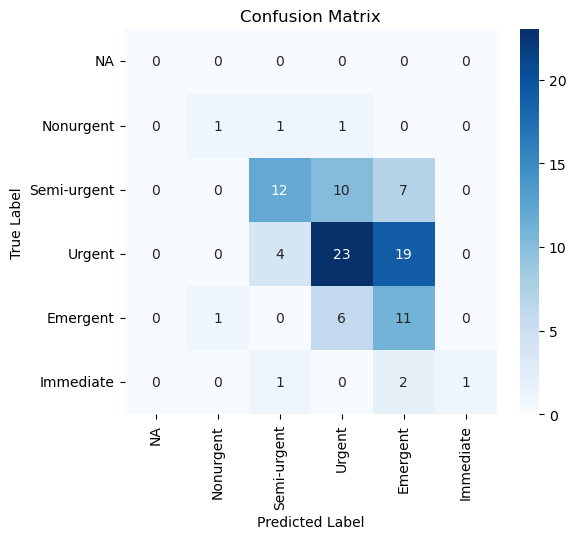

Undereporting % (predicted < true) of wrong predictions: 26.92%
Overreporting % (predicted > true) of wrong predictions: 73.08%


In [174]:
global_metrics(true_labels, predictions, levels=["Immediate", "Emergent", "Urgent", "Semi-urgent", "Nonurgent", "NA"])


Per Triage Level Metrics:

Triage Level: Immediate
Accuracy: 0.250
Confusion Matrix:
[[96  3]
 [ 0  1]]


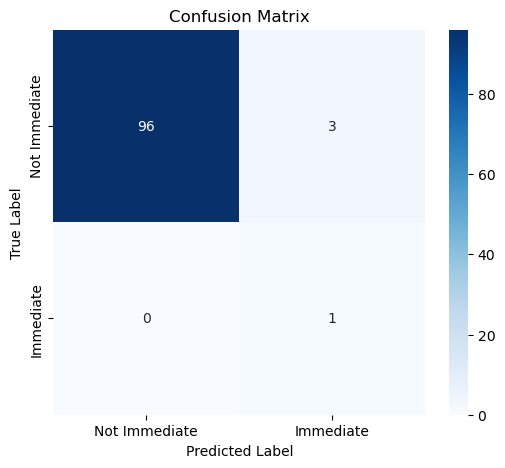

Undereporting % (predicted < true) of wrong predictions: 100.00%
Overreporting % (predicted > true) of wrong predictions: 0.00%

Triage Level: Emergent
Accuracy: 0.611
Confusion Matrix:
[[54  7]
 [28 11]]


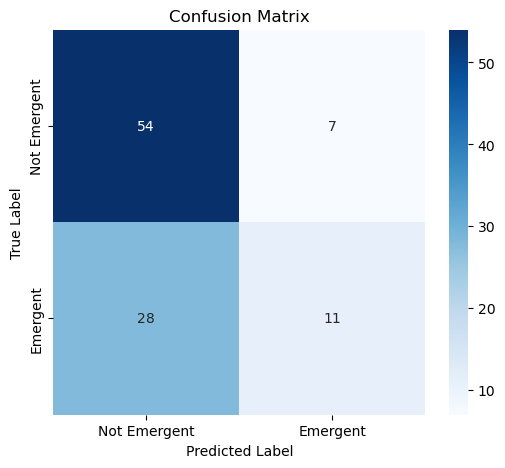

Undereporting % (predicted < true) of wrong predictions: 100.00%
Overreporting % (predicted > true) of wrong predictions: 0.00%

Triage Level: Urgent
Accuracy: 0.500
Confusion Matrix:
[[37 23]
 [17 23]]


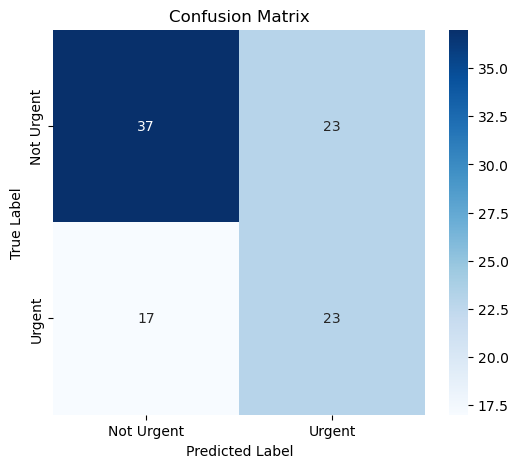

Undereporting % (predicted < true) of wrong predictions: 17.39%
Overreporting % (predicted > true) of wrong predictions: 82.61%

Triage Level: Semi-urgent
Accuracy: 0.414
Confusion Matrix:
[[65 17]
 [ 6 12]]


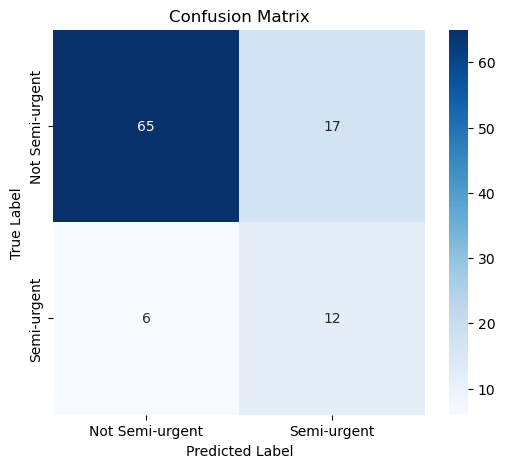

Undereporting % (predicted < true) of wrong predictions: 0.00%
Overreporting % (predicted > true) of wrong predictions: 100.00%

Triage Level: Nonurgent
Accuracy: 0.333
Confusion Matrix:
[[96  2]
 [ 1  1]]


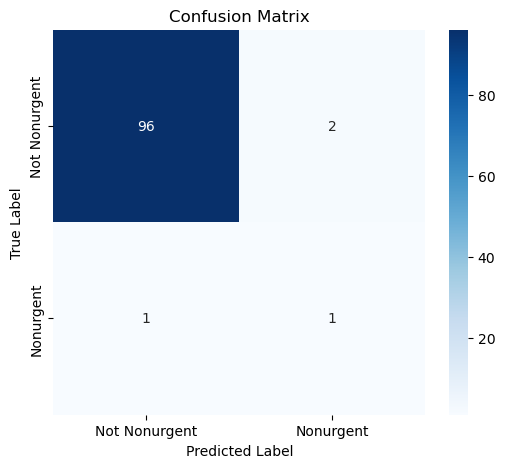

Undereporting % (predicted < true) of wrong predictions: 0.00%
Overreporting % (predicted > true) of wrong predictions: 100.00%

No cases of Triage Level: NA



In [175]:
per_triage_level_metrics(true_labels, predictions, levels=["Immediate", "Emergent", "Urgent", "Semi-urgent", "Nonurgent", "NA"])

In [ ]:
system_prompt_old = """
I need you to act as an expert ER Doctor who will assign medical triage based on the Emergency Severity Index (ESI) classification. You will carefully evaluate the following patient summary and assign an appropriate triage score.
Patient Summary:
"""

system_prompt_old2 = """

For context, here's how the ESI classification works:
The ESI assigns patients to one of five levels based on the severity of their condition and the medical resources they are likely to require:
Level 1 (Immediate): Life-threatening - Requires immediate intervention to prevent death. Examples include cardiac arrest, severe trauma, and airway obstruction.
Level 2 (Emergent): High-risk symptoms or unstable - Could quickly become life-threatening without prompt care. Examples include chest pain with sweating, stroke signs, respiratory distress, and signs of shock.
Level 3 (Urgent): Requires multiple resources but is currently stable. An example would be abdominal pain needing both a CT scan and lab work.
Level 4 (Semi-Urgent): Requires one resource, stable condition. An example would be a possible fracture needing an X-ray.
Level 5 (Non-Urgent): Requires no resources, minimal medical need. An example would be a minor cut or a medication refill.
 
Key ESI Decision Factors:
Immediate life-saving intervention:
If the patient requires immediate action to maintain airway, breathing, or circulation (e.g., intubation, CPR, defibrillation), assign to Level 1.

High-risk clinical symptoms:
High-risk symptoms that could rapidly deteriorate without prompt care include severe chest pain, stroke signs (e.g., facial droop, arm weakness, speech difficulty), severe respiratory distress (e.g., struggling to breathe), signs of shock (e.g., hypotension, weak pulse, cold/clammy skin), acute neurological deficit, uncontrolled bleeding, and sepsis or suspected sepsis. If present, assign to Level 2.

Altered mental status or severe distress:
If the patient is confused, disoriented, unconscious, or unable to respond appropriately, or if they are in extreme emotional or physical distress (e.g., severe agitation, intense pain), assign to Level 2.

Number of resources required:
Resources include labs (bloodwork, urinalysis), imaging (X-ray, CT, MRI), IV fluids, specialty consults, medications (IV, IM, PO), and procedures (suturing, splinting, casting). If no resources are required, assign to Level 5. If one resource is required, assign to Level 4. If two or more resources are needed, move to Step 5.

Vital sign instability (Danger-Zone Vitals):
Check the patient's vitals for signs of instability. Danger-zone values include heart rate > 100 bpm, respiratory rate > 20 breaths/min, oxygen saturation ≤ 92%, systolic blood pressure < 90 mmHg (hypotension), and temperature ≥ 38.0°C (100.4°F) or ≤ 36.0°C (96.8°F). If vitals are unstable, assign to Level 2. If vitals are stable, assign to Level 3.

Triage Severity Index:
II: Level 1 (Immediate)
III: Level 2 (Emergent)
IV: Level 3 (Urgent)
VI: Level 4 (Semi-Urgent)
VII: Level 5 (Non-Urgent)

Evaluation Instructions:
After reviewing the patient summary, please:
List all the key symptoms and risk factors present in the case.
Explain how each symptom contributes to the overall triage decision.
Describe any assumptions you make to fill in missing data or clarify uncertainties.
Identify any gaps or missing information that prevent a confident diagnosis.
Final Triage Level:
Based on your reasoning, assign a final triage level (Level 1 to Level 5) and explain why this is the most appropriate classification. State the final triage level clearly in the format:
"The triage level is [Level X] because [reasoning]."
 
Verification and Reassessment:
After providing your triage reasoning:
Double-check that all symptoms and risk factors have been accounted for.
Identify any assumptions you made and clarify areas where certainty is lower.
Correct any discrepancies or contradictions.
Provide a brief summary of the verification process.
 
Important Notes:
Use clear, professional language.
Provide a structured, logical chain of thought, each in their own reasoning step.
If you cannot make a confident decision due to missing or unclear data, state “I cannot make a decision” and explain what additional information is needed.

Please output the appropriate number of "reasoning_steps", "triage_severity_index" and "triage_level" in json format. 

EXAMPLE INPUT: 
A 25.0-year-old female arrived by private vehicle at the ED with an non-injury visit. The patient reported the following primary complaint(s): Toothache, Edema. Recorded vital signs include temperature 98.1, pulse 96.0, blood pressure 108.0/64.0, respiratory rate 18.0, and O₂ saturation 98.0%. Pain scale was noted as 6.0. The patient has a total of 2.0 chronic condition(s), including: none. Possible cause(s) related to this visit: no specific causes reported.

EXAMPLE OUTPUT:
'''json
{
    "reasoning_step_1": "Identify the chief complaint(s): The patient's primary concerns are a severe headache, pain in the head, and vomiting. The pain scale is rated at 10.0, which indicates extreme discomfort.",
    "reasoning_step_2": "Assess vital signs: The temperature is 98.6°F, which is within the normal range. The pulse is 82.0, slightly elevated, and blood pressure is 125.0/67.0, indicating a hypertensive state. Respirations and oxygen saturation are not provided, but since there's no mention of respiratory distress, these may not be immediately relevant.",
    "reasoning_step_3": "Evaluate the nature of symptoms: A severe headache and vomiting could be indicative of various issues, such as a migraine, intracranial hemorrhage, stroke, or other neurological disorders. The high pain scale suggests that the patient is in considerable distress.",
    "reasoning_step_4": "Determine the urgency: Given the high pain score, the patient is likely in immediate need of medical attention. Without specific information pointing to a less urgent condition, the presence of severe symptoms necessitates an urgent triage level.",
    "reasoning_step_5": "Conclusion: The combination of a severe headache, vomiting, and high pain score necessitates an urgent triage level to rule out life-threatening conditions and provide appropriate treatment.",
    "triage_severity_index": "IV",
    "triage_level": "Urgent",
    "verification_and_reassessment": "All key symptoms and risk factors have been considered, and the decision is supported by the severity of the patient's condition. No discrepancies or contradictions are present."
}
'''
"""

In [192]:
# import textwrap
# case = deepseek_v3_output_df.iloc[2]

# #print (case)
# #print("\n".join(textwrap.wrap(case, width=120)))  # Inspect one formatted example
# #   # Inspect one formatted example

# clinical_note = case["clinical_note"]
# predicted_triage = case["predicted_triage"]
# true_label = case["true_triage"][:-1]
# reasoning = case["reasoning"]

# print(f"\nClinical Note:\n   ")
# print("\n".join(textwrap.wrap(clinical_note, width=120)))

# print(f"\nV3 Reasoning:\n    ")
# print("\n".join(textwrap.wrap(reasoning, width=120)))

# print("\nV3 Triage Level:\n    ", predicted_triage)

# full_output = call_deepseek_r1(clinical_note, predicted_triage, reasoning)

# print(f"\nFull model output:\n    ")
# print("\n".join(textwrap.wrap(full_output, width=120)))
# match_pred = re.search(r'<triage_classification>(.*?)</triage_classification>', full_output)
# predicted_label = match_pred.group(1).strip() if match_pred else None

# match_discrepancy = re.search(r'<discrepancy>(.*?)</discrepancy>', full_output)
# discrepancy = match_discrepancy.group(1).strip() if match_discrepancy else None

# print(f"\nPredicted Triage Level:\n    {predicted_label}")
# print(f"\nDiscrepancy:\n    {discrepancy}")
# print("\nGround Truth Triage Level:\n    ", true_label)

In [193]:
# print(f"\nPredicted Triage Level:\n    {triage_mapping.get(predicted_label)}")
# print(f"\nDiscrepancy:\n    {discrepancy}")
# print("\nGround Truth Triage Level:\n    ", true_label)